In [1]:
import pandas as pd
import mysql.connector
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# First buyer: Top 5 romance genre author

In [2]:
db = mysql.connector.connect(
   host="localhost",
  user="root",
  password="",
  database="Booktopia")
mycursor = db.cursor()

In [3]:
sql_quary = """
            SELECT DISTINCT wp.name,
                ((avg(score) - 3.5) / (4.4 - 3.5)) * 0.5 +
                ((count(reward) - 1) / (39 - 1)) * 0.2 +
                ((avg(edition / (2024 - (bd.ad_publication_year))) - 0.1) / (13.2 - 0.1)) * 0.3
                AS writer_score
            FROM book_detail bd
            INNER JOIN book_summary bs ON bs.site_id = bd.site_id
            INNER JOIN writer w ON w.site_id = bs.site_id
            INNER JOIN writer_page wp ON wp.writer_id = w.writer_id
            INNER JOIN translator t ON t.book_id = bd.book_id
            INNER JOIN translator_page tp ON tp.translator_id = t.translator_id
            INNER JOIN rewards r ON r.site_id = bd.site_id
            INNER JOIN book_tag bt ON bt.site_id = bd.site_id
            INNER JOIN tags ta ON ta.id = bt.tag_id
            WHERE bd.book_language = 'فارسی'
            AND ta.name IN ('داستان عاشقانه', 'داستان درام', 'فهرست بهترین رمان های عاشقانه')
            AND bd.ad_publication_year BETWEEN 1800 AND 2023
            AND edition != -1
            GROUP BY t.translator_id
            ORDER BY writer_score DESC
            LIMIT 5;
        """
mycursor.execute(sql_quary)

- In order to determine the appropriate criteria for ranking authors, we used the rating of each book, the number of awards, and the series editions of each book, taking into account the number of years since its publication (so that newly emerging books are also adequately valued).
- َ The data has been normalized for a better scale with this formula ----> x - Min(x) / Max(x) - Min(x)

In [4]:
# adding result of quary to dataframe 
columns = [i[0] for i in mycursor.description]
result = mycursor.fetchall()
df = pd.DataFrame(result, columns=columns)



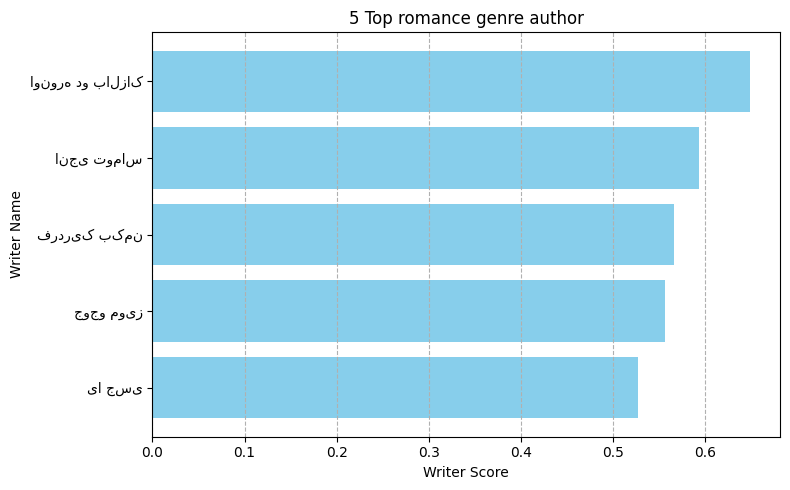

In [5]:
# Plot data
plt.figure(figsize=(8, 5))  
plt.barh(df['name'], df['writer_score'], color='skyblue')
plt.xlabel('Writer Score')
plt.ylabel('Writer Name')
plt.title('5 Top romance genre author')
plt.gca().invert_yaxis()  # Invert the y-axis to display the highest score at the top
plt.grid(axis='x', linestyle='--', alpha=1)
plt.tight_layout()
plt.show()

# Second buyer : Cheap but high quality 

In [6]:
db = mysql.connector.connect(
   host="localhost",
  user="root",
  password="",
  database="Booktopia")
mycursor = db.cursor()

In [7]:
sql_quary = """
SELECT
    book_detail.site_id,
    book_detail.English_title,
    book_detail.score,
    book_detail.edition,
    book_detail.stock_status,
    book_detail.ad_publication_year,
    book_detail.solar_publication_year,
    price_history.price,
    rewards.reward
FROM
    book_detail
JOIN
    price_history ON book_detail.site_id = price_history.book_id
JOIN
    rewards ON book_detail.site_id = rewards.site_id
WHERE
    book_detail.stock_status = ' موجود ';
"""
mycursor.execute(sql_quary)

In [8]:
results = mycursor .fetchall()
df = pd.DataFrame(results, columns=[i[0] for i in mycursor.description])
df['price'] = pd.to_numeric(df['price'], errors='coerce')
price_threshold = df['price'].quantile(0.2)
cheapest_books = df[df['price'] <= price_threshold]
df = cheapest_books
df.reset_index(drop=True, inplace=True)

In [9]:
#normalized data 
normalized_reward = df.groupby('site_id').count()['reward']
max_reward = normalized_reward.quantile(0.9)
normalized_reward = normalized_reward / max_reward
normalized_reward[normalized_reward > 1] = 1
normalized_reward[normalized_reward < 0] = 0
df = df.groupby('site_id').agg(
    {'score': 'first', 'edition': 'first', 'ad_publication_year': 'first', 'reward': 'count','English_title': 'first'})
normalized_score = (df['score'] / 5).astype('float64')
normalized_edition = df['edition'] / (2024 - df['ad_publication_year']) * 2
max_edition = normalized_edition.quantile(0.9)
normalized_edition = normalized_edition / max_edition
normalized_edition[normalized_edition > 1] = 1
normalized_edition[normalized_edition < 0] = 0
# max_edition

In [10]:
df['Books_score'] = ((normalized_edition * 0.3) + (normalized_score * 0.2) + normalized_reward * 0.5)
df=df.sort_values(by='Books_score',ascending=False)
top_books = df.head(10)

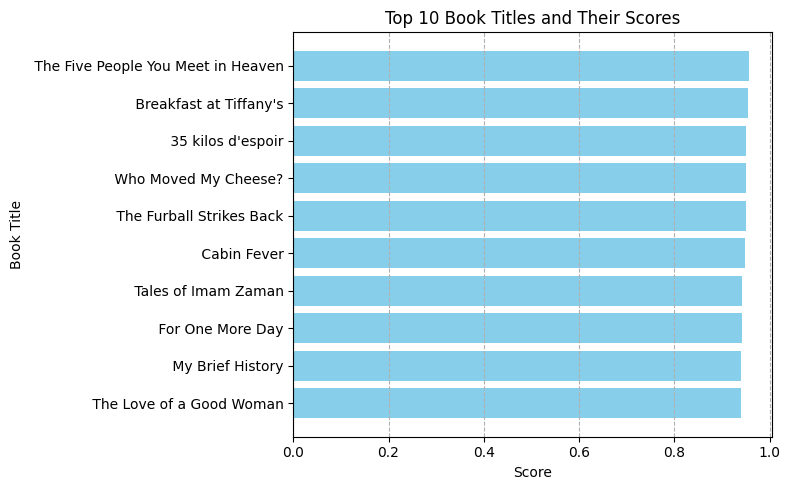

In [33]:
#plot Data
plt.figure(figsize=(8, 5))
plt.barh(top_books['English_title'], top_books['Books_score'], color='skyblue')
plt.grid(axis='x', linestyle='--', alpha=1)
plt.xlabel('Score')
plt.ylabel('Book Title')
plt.title('Top 10 Book Titles and Their Scores')
plt.gca().invert_yaxis()  
plt.tight_layout()
plt.show()


# The writer's request :5 Top historical publisher


In [12]:
db = mysql.connector.connect(
   host="localhost",
  user="root",
  password="",
  database="Booktopia")
mycursor = db.cursor()

In [13]:
sql_quary = """
SELECT p.name AS publisher_name,(
    ((AVG(bd.score) - 3) / (5 - 3)) * 0.4+
    ((COUNT(*) - 1) / (216 - 1)) * 0.6) AS publisher_score
FROM book_detail AS bd
JOIN publisher AS p ON bd.publisher_id = p.id
JOIN book_tag AS bt ON bd.site_id = bt.site_id
JOIN tags AS t ON bt.tag_id = t.id
WHERE t.name in ('داستان تاریخی درام' ,'تاریخی')
GROUP BY p.id, p.name
ORDER BY publisher_score DESC
limit 5  ;
"""
mycursor .execute(sql_quary)

- Our criterion for determining the best publications is the average ratings of published books and the number of books published in this genre.
- The data has been normalized for a better scale with this formula ----> x - Min(x) / Max(x) - Min(x)


In [14]:
# adding result of quary to dataframe
column = [k[0] for k in mycursor .description]
results = mycursor .fetchall()
df1 = pd.DataFrame(results, columns=column)



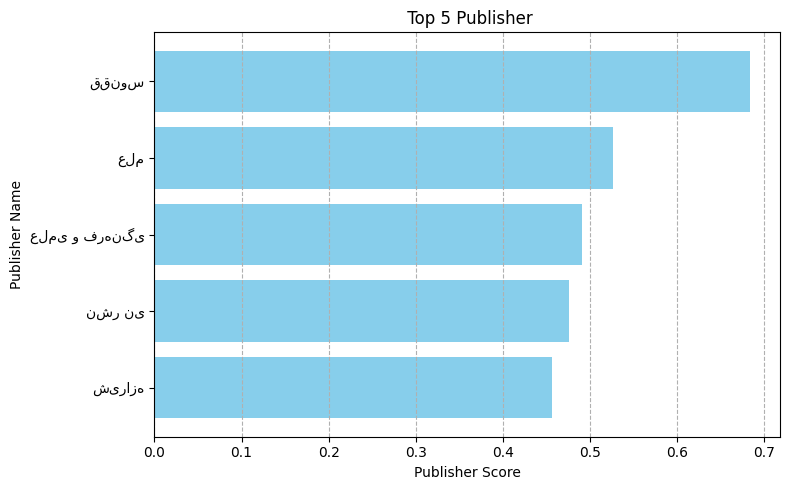

In [15]:
#plot data
plt.figure(figsize=(8, 5))  
plt.barh(df1['publisher_name'], df1['publisher_score'], color='skyblue')
plt.xlabel('Publisher Score')
plt.ylabel('Publisher Name')
plt.title(' Top 5 Publisher')
plt.gca().invert_yaxis()  # Invert the y-axis to display the highest score at the top
plt.grid(axis='x', linestyle='--', alpha=1)
plt.tight_layout()
plt.show()

# First hypothesis :

In [16]:
db = mysql.connector.connect(
   host="localhost",
  user="root",
  password="",
  database="Booktopia")
mycursor = db.cursor()

In [17]:
sql_quary = """
            select bd.english_title as book_name , ph.price as price
            from book_detail bd
            inner join Price_history ph on ph.book_id = bd.book_id
            where bd.book_language ='انگلیسی' and bd.stock_status = ' موجود 'and bd.cover_id = 0
            group by bd.english_title, ph.price
            order by price desc ;
            """
mycursor.execute(sql_quary)

In [18]:
# adding result of quary to dataframe
columns = [i[0] for i in mycursor.description]
result = mycursor.fetchall()
dfenglish = pd.DataFrame(result, columns=columns)

In [19]:
sql_quary = """
            select bd.english_title as book_name , ph.price as price
            from book_detail bd
            inner join Price_history ph on ph.book_id = bd.book_id
            where bd.book_language ='فارسی' and bd.stock_status =  ' موجود 'and bd.cover_id = 0
            group by bd.english_title, ph.price
            order by price desc ;
            
            """
mycursor.execute(sql_quary)

In [20]:
# adding result of quary to dataframe
column = [k[0] for k in mycursor.description]
results = mycursor.fetchall()
dfpersian = pd.DataFrame(results, columns=column)


In [21]:
# just get common book between translated persian book and english book to improve statical sample
common_book_pe = dfpersian[dfpersian['book_name'].isin(dfenglish['book_name'])]
common_book_en = dfenglish[dfenglish['book_name'].isin(dfpersian['book_name'])]

price_english = common_book_en['price'].tolist()
price_persian = common_book_pe['price'].tolist()

In [22]:
t_statistic, p_value = ttest_ind(price_persian,price_english, equal_var=False)
print("T-Statistic:", t_statistic)
print("P-Value:", p_value)

T-Statistic: -1.1231592100568097
P-Value: 0.2644471642744679


- The t-statistic is a measure to indicate the difference the means .
-  In this case the t-statistic is approximately -1.123. Since this value is negative,it's explain that the price of persian books (translated book ) are slightly lower than the prices of English books.
- P-Value: The p-value is a crucial component of hypothesis test.
- In this case the P-Value is 0.2644471642744679 that is  is greater than 0.05.
- So the p-value suggests that there isn't enough evidence to reject the null hypothesis, meaning that you don't have strong statistical evidence to conclude that there is a significant difference in book prices between English and Persian books.
- A slight price difference may be due to a reduction in the number of pages in the book after translation or the fact that the publisher is not Iranian( Dollar price :) )


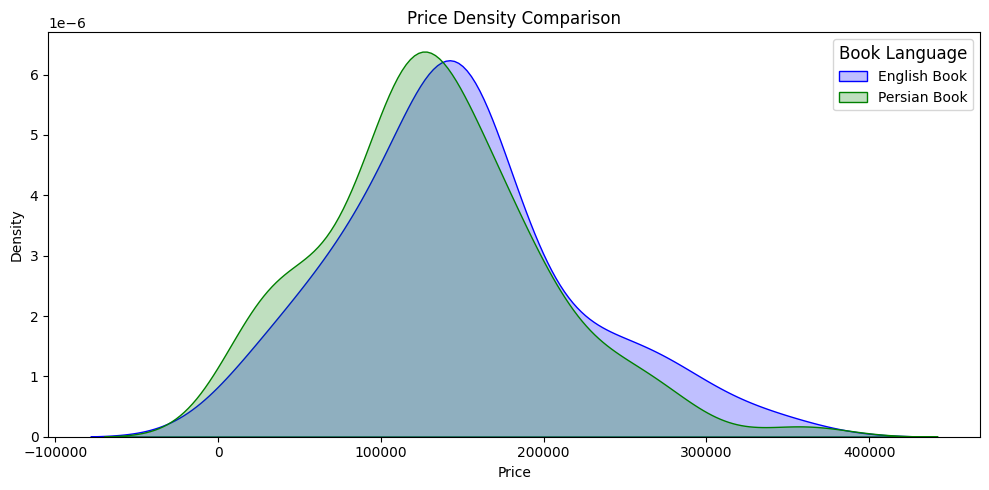

In [23]:
# plot data
plt.figure(figsize=(10, 5))
sns.kdeplot(data=common_book_en, x="price", fill=True, common_norm=False, color="blue", label="English Book")
sns.kdeplot(data=common_book_pe, x="price", fill=True, common_norm=False, color="green", label="Persian Book")
plt.xlabel('Price')
plt.ylabel('Density')
plt.title('Price Density Comparison')
plt.tight_layout()
legend = plt.legend(title="Book Language", loc="upper right")
legend.get_title().set_fontsize(12)
plt.show()


-As can also be seen from the chart, it is not possible to discern the difference between the prices of translated and untranslated books with the naked eye, and this difference is negligible.

# Second hypothesis :

In [24]:
db = mysql.connector.connect(
   host="localhost",
  user="root",
  password="",
  database="Booktopia")
mycursor = db.cursor()

In [25]:
sql_quary = """ 
select bd.English_title as book_name, ph.price as price_shoomiz
from book_detail bd
inner join Price_history ph on ph.book_id = bd.book_id
where  bd.cover_id = 0 and bd.stock_status = ' موجود '
order by price desc ;"""
mycursor.execute(sql_quary)


In [26]:
column = [k[0] for k in mycursor.description]
results = mycursor.fetchall()
dfshoomiz = pd.DataFrame(results, columns=column)


In [27]:
sql_quary = """ 
select  bd.English_title as book_name, ph.price as price_hardcover
from book_detail bd
inner join Price_history ph on ph.book_id = bd.book_id
where  bd.cover_id = 2 and bd.stock_status = ' موجود '
order by price desc ;"""
mycursor.execute(sql_quary)

In [28]:
column = [k[0] for k in mycursor.description]
results = mycursor.fetchall()
dfhard_cover = pd.DataFrame(results, columns=column)


In [29]:
common_book_shoomiz = dfshoomiz [dfshoomiz ['book_name'].isin(dfhard_cover['book_name'])]
common_book_hardcover = dfhard_cover[dfhard_cover['book_name'].isin(dfshoomiz ['book_name'])]

price_shoomiz = common_book_shoomiz['price_shoomiz'].tolist()
price_hardcover= common_book_hardcover['price_hardcover'].tolist()

In [30]:
t_statistic, p_value = ttest_ind(price_hardcover,price_shoomiz, equal_var=False)
print("T-Statistic:", t_statistic)
print("P-Value:", p_value)


T-Statistic: 15.361368761038646
P-Value: 1.5364140147844062e-45


-T-Statistic: 15.361368761038646
The t-statistic is a measure of how different the means of the two groups (price_hardcover and price_shoomiz) are. In this case, a t-statistic of 15.361 suggests that there is a significant difference between the two groups' means.

-P-Value: 1.5364140147844062e-45
The p-value is extremely small . A small p-value indicates strong evidence against the null hypothesis. In hypothesis testing, it is common to use a significance level (alpha), such as 0.05. If the p-value is less than alpha, you typically reject the null hypothesis. In this case, with a p-value much smaller than 0.05, you would likely reject the null hypothesis and conclude that there is a significant difference in prices between the two groups.

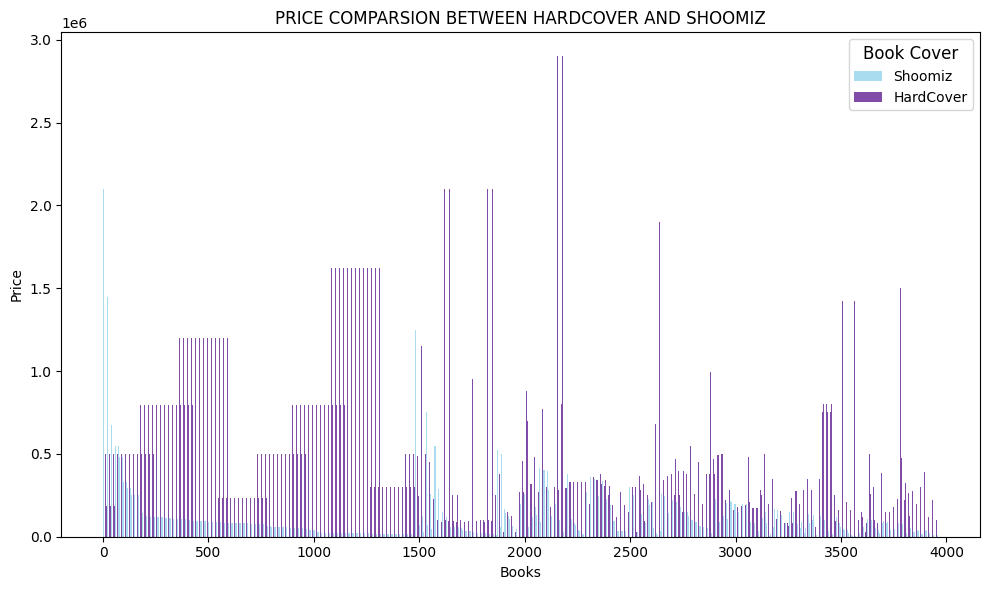

In [31]:

merged_df = pd.merge(common_book_shoomiz, common_book_hardcover, on='book_name', how='inner')
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = range(len(merged_df))
plt.bar(index, merged_df['price_shoomiz'], bar_width, label='Shoomiz', color='skyblue', alpha=0.7)
plt.bar([i + bar_width for i in index], merged_df['price_hardcover'], bar_width, label='HardCover', color='indigo', alpha=0.7)
plt.xlabel('Books')
plt.ylabel('Price')
plt.title('PRICE COMPARSION BETWEEN HARDCOVER AND SHOOMIZ')
plt.legend()
legend = plt.legend(title="Book Cover", loc="upper right")
legend.get_title().set_fontsize(12)
plt.tight_layout()
plt.show()


In support of this assumption, it can be said that:

1. **Increased Production Costs**: The use of hardcover and more expensive materials for bookbinding increases the production costs of a book. As a result, the price of the book tends to increase with this type of binding.

2. **Quality and Durability**: Hardcover books generally have higher quality and durability. They are less prone to damage or wear and tear. Additionally, their covers are often more attractive and fancier. Many people choose hardcover books when giving them as gifts. Consequently, these factors contribute to an increase in the price of hardcover books.